In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from num2words import num2words
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud, STOPWORDS 
from collections import Counter
import re
from textblob import TextBlob
from scipy.sparse import hstack
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from xgboost import XGBClassifier
from google_trans_new import google_translator  
import pickle

In [2]:
df1 = pd.read_csv("Constraint_Train.csv")
df2 = pd.read_csv("english_test_with_labels.csv")

In [3]:
df = pd.concat([df1, df2])

In [4]:
df = df[df['id'] != 4287]
df = df[df['id'] != 4698]
df = df.sample(frac=1).reset_index(drop=True)

# Preprocessing

In [5]:
def convert_lower_case(data):
    return np.char.lower(data)

In [6]:
def remove_urls_hashtag(data):
    words = word_tokenize(str(data))
    j = 0
    new_text = ""
    while(j<len(words)): 
        if 'http' in words[j] or 'www' in words[j]:
            j = j+3
        elif '#' in words[j]:
            j = j+2
        else:
            new_text = new_text + words[j] + " "
            j = j+1
    return new_text

In [7]:
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words:
            new_text = new_text + " " + w
    return new_text

In [8]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', ' ')
    data = np.char.replace(data, "'", "")
    data = np.char.replace(data, "'", "")
    return data

In [9]:
def lemmatizing(data):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text

In [10]:
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

In [11]:
def convert_contractions(data):
    APPO = {"ain't": "am not", "aren't" : "are not", "can't" : "cannot", "'cause": "because",
    "couldn't" : "could not", "didn't" : "did not", "doesn't" : "does not", "don't" : "do not",
    "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "he'd" : "he would",
    "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'll" : "I will",
    "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", 
    "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not",
    "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is",
    "shouldn't" : "should not", "that's" : "that is", "there's" : "there is", "they'd" : "they would",
    "they'll" : "they will", "they're" : "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are",
    "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are",
    "what's" : "what is", "what've" : "what have", "where's" : "where is", "who'd" : "who would",
    "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have",
    "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will",
    "you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not",
    "we'll":" will", "we're": "we are", "we've": "we have", "didn't": "did not", "tryin'":"trying"}
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w in APPO:
            new_text = new_text + " " + APPO[w]
        else:
            new_text = new_text + " " + w
    return new_text

In [12]:
def remove_single(data):
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if len(w) > 2:
            new_text = new_text + " " + w
    return new_text

In [13]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_urls_hashtag(data)
    data = convert_contractions(data)
    data = remove_single(data)
    data = remove_punctuation(data)
    data = remove_stop_words(data)
    data = lemmatizing(data)
    data = remove_single(data)
    return data

In [14]:
def preprocess_senti(data):
    data = convert_lower_case(data)
    data = remove_urls_hashtag(data)
    data = convert_contractions(data)
    data = remove_single(data)
    data = remove_punctuation(data)
    data = lemmatizing(data)
    data = remove_single(data)
    return data

In [15]:
preprocessed_txt_senti = []
preprocessed_txt = []
for i in df['tweet']:
    preprocessed_txt_senti.append(str(preprocess_senti(i)))
    preprocessed_txt.append(str(preprocess(i)))

In [16]:
df_clean_senti = df.copy(deep=True)
df_clean = df.copy(deep=True)

In [17]:
df_clean_senti['tweet'] = preprocessed_txt_senti
df_clean['tweet'] = preprocessed_txt

In [18]:
df_clean

,id,tweet,label
0,2077,minhealthnz new case report today update also...,real
1,4628,coronavirus road killed bat,fake
2,1078,pib clarified pmsby cover covid related death...,fake
3,2119,covid hospital flooded bihar,fake
4,4486,study showed million people north carolina ex...,fake
...,...,...,...
8553,3656,men scramble find personality cdc suggests sh...,fake
8554,1727,type type diabetes associated much higher ris...,real
8555,2348,photo woman lying hospital bed medical equipm...,fake
8556,524,three case man two child arrived together dub...,real


In [19]:
df_clean_senti.to_csv('Preprocessed Dataset Sentiment.csv')
df_clean.to_csv('Preprocessed Dataset.csv')

In [20]:
df_clean_senti = pd.read_csv('Preprocessed Dataset Sentiment.csv').drop(['Unnamed: 0'],axis=1)
df_clean = pd.read_csv('Preprocessed Dataset.csv').drop(['Unnamed: 0'],axis=1)

In [21]:
# 4698, 4287
df_clean = df_clean.dropna().reset_index(drop=True)
df_clean_senti = df_clean_senti.dropna().reset_index(drop=True)

# Exploratory Data Analysis (EDA)

In [22]:
df_real = df_clean[df_clean['label'] == 'real']

In [23]:
df_fake = df_clean[df_clean['label'] == 'fake']

In [42]:
print('Number of real labels ',len(df_real))
print('Number of fake labels ',len(df_fake))

Number of real labels  4480
Number of fake labels  4078


## Top 10 Unigrams (Real News)

In [25]:
unigram_text = []
for i in df_real['tweet']:
    unigram_text += word_tokenize(i)

In [26]:
unigram_count = Counter(unigram_text).most_common()[:10]

In [27]:
unigrams = {i[0]:i[1] for i in unigram_count}

### Plot

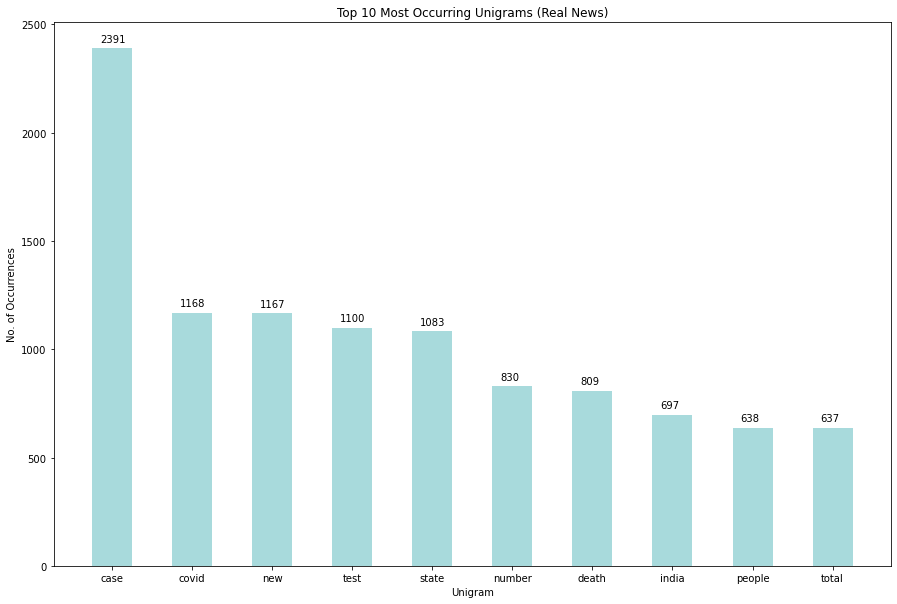

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(unigrams.keys(), unigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(unigrams.values()):
    ax.text(i-0.15, v+30, str(round(v,2)))
plt.title('Top 10 Most Occurring Unigrams (Real News)')
plt.xlabel('Unigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Top 10 Bigrams (Real News)

In [29]:
bigram_text = []
for i in df_real['tweet']:
    bigram_text.append(i)

In [30]:
bigram_tokens = []
for i in bigram_text:
    tokens = word_tokenize(i)
    for j, x in enumerate(tokens):
        if j < len(i.split()) - 1:
            bigram_tokens.append(x + " " + tokens[j+1])

In [31]:
bigram_count = Counter(bigram_tokens).most_common()[:10]

In [32]:
bigrams = {i[0]:i[1] for i in bigram_count}

### Plot

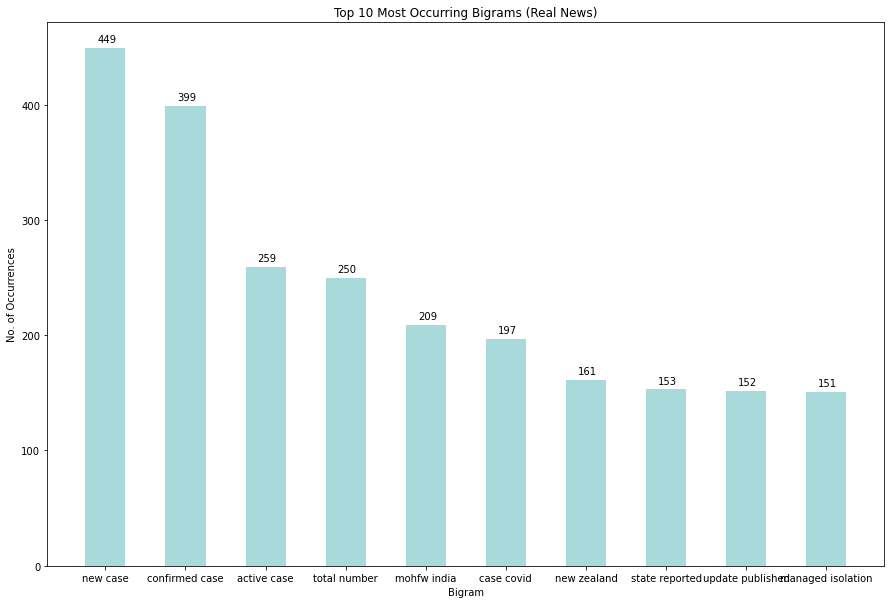

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(bigrams.keys(), bigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(bigrams.values()):
    ax.text(i-0.1, v+5, str(round(v,2)))
plt.title('Top 10 Most Occurring Bigrams (Real News)')
plt.xlabel('Bigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Top 10 Unigrams (Fake News)

In [34]:
unigram_text = []
for i in df_fake['tweet']:
    unigram_text += word_tokenize(i)

In [35]:
unigram_count = Counter(unigram_text).most_common()[:10]

In [36]:
unigrams = {i[0]:i[1] for i in unigram_count}

### Plot

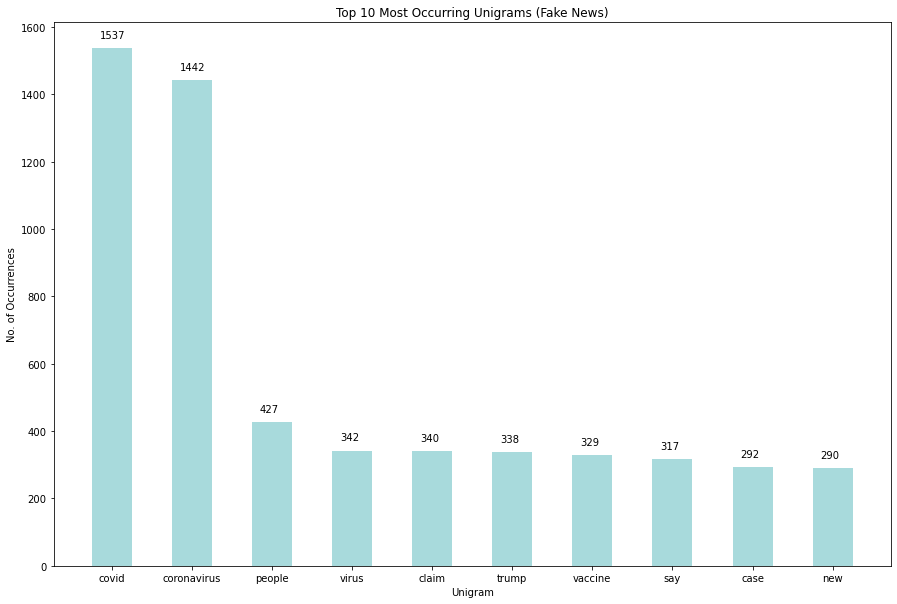

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(unigrams.keys(), unigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(unigrams.values()):
    ax.text(i-0.15, v+30, str(round(v,2)))
plt.title('Top 10 Most Occurring Unigrams (Fake News)')
plt.xlabel('Unigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Top 10 Bigrams (Fake News)

In [38]:
bigram_text = []
for i in df_fake['tweet']:
    bigram_text.append(i)

In [39]:
bigram_tokens = []
for i in bigram_text:
    tokens = word_tokenize(i)
    for j, x in enumerate(tokens):
        if j < len(i.split()) - 1:
            bigram_tokens.append(x + " " + tokens[j+1])

In [40]:
bigram_count = Counter(bigram_tokens).most_common()[:10]

In [43]:
bigrams = {i[0]:i[1] for i in bigram_count}

### Plot

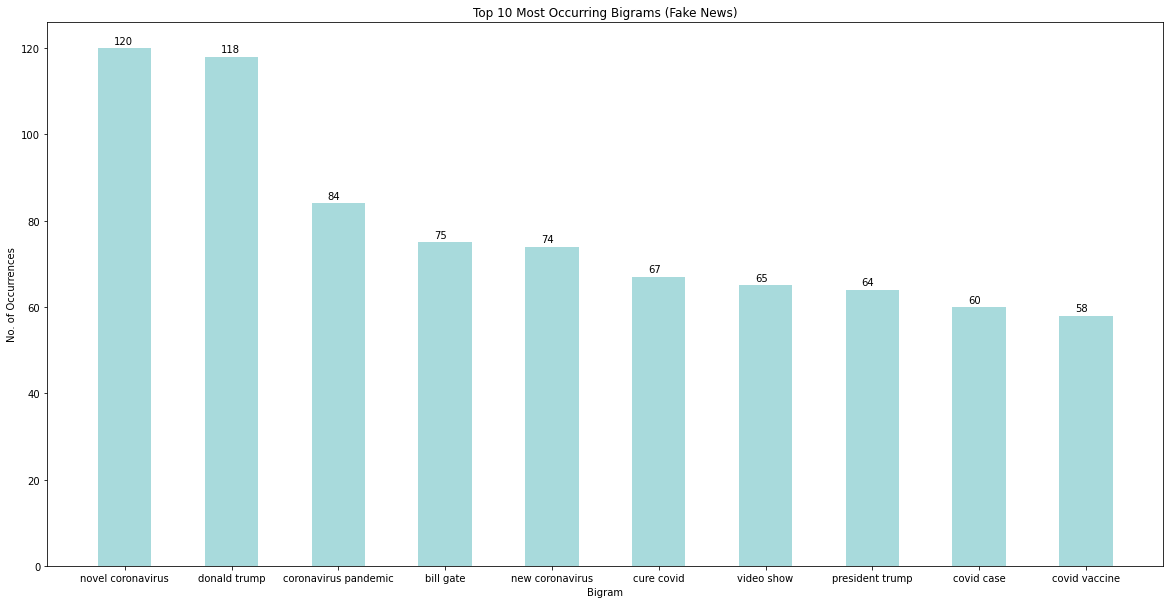

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(bigrams.keys(), bigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(bigrams.values()):
    ax.text(i-0.1, v+1, str(round(v,2)))
plt.title('Top 10 Most Occurring Bigrams (Fake News)')
plt.xlabel('Bigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Word Cloud of Real News

In [45]:
real_text = ""
for i in df_real['tweet']:
    real_text += i + " "

In [46]:
stop_words = set(STOPWORDS)

In [47]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(real_text)

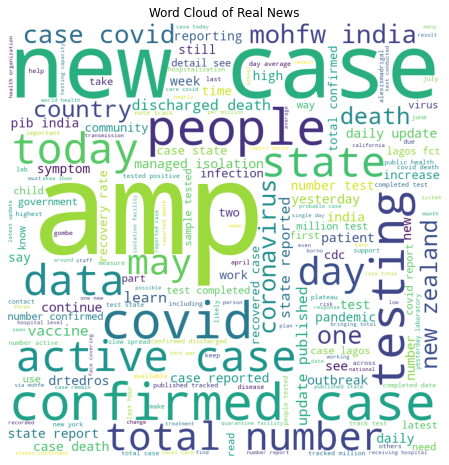

In [48]:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.title('Word Cloud of Real News')
plt.axis("off")
plt.show()

## Word Cloud of Fake News

In [49]:
fake_text = ""
for i in df_fake['tweet']:
    fake_text += i + " "

In [50]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(fake_text)

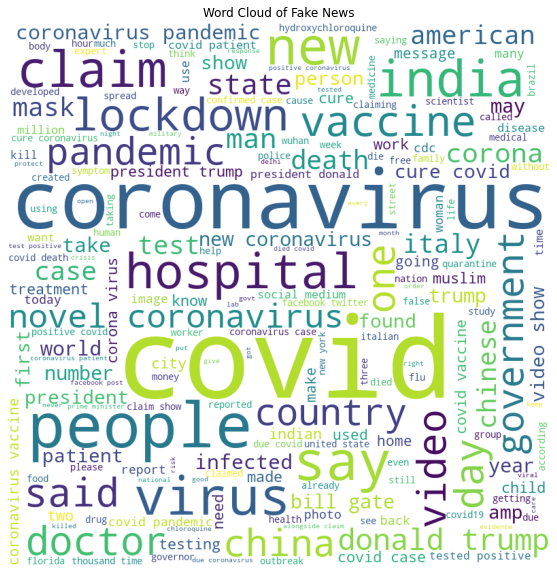

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title('Word Cloud of Fake News')
plt.axis("off")
plt.show()

# Feature Extraction
We've broadly classified our feature engineering ideas in the following two groups:

## Direct Features:
Following techniques will be used under Direct Features:  
1. Bag of Words (Unigram, Bigram, Trigrams)  
    a. Count Vectorizer  
    b. TF-IDF Vectorizer
2. Word Embeddings (Example: GloVe)  

## Indirect Features:
Following features will be used under Indirect Features:  
1. Count of Words (Length of a Tweet)  
2. Count of Unique Words  
3. Count of Letters  
4. Count of Stop Words  
5. Polarity Score  
6. Subjectivity Score

## Indirect Features

In [52]:
# Word Count
df['count_words'] = df['tweet'].apply(lambda x: len(str(x).split()))
MinMax1 = MinMaxScaler()
df['count_words'] = MinMax1.fit_transform(np.array(df['count_words']).reshape(-1,1))
filename1 = 'MinMax1.sav'
pickle.dump(MinMax1, open(filename1, 'wb'))

In [53]:
# Unique Word Count
df['count_unique_words'] = df['tweet'].apply(lambda x: len(set(str(x).split())))
MinMax2 = MinMaxScaler()
df['count_unique_words'] = MinMax2.fit_transform(np.array(df['count_unique_words']).reshape(-1,1))
filename2 = 'MinMax2.sav'
pickle.dump(MinMax2, open(filename2, 'wb'))

In [55]:
# Letter Count
df['count_letters'] = df['tweet'].apply(lambda x: len(str(x)))
MinMax3 = MinMaxScaler()
df['count_letters'] = MinMax3.fit_transform(np.array(df['count_letters']).reshape(-1,1))
filename3 = 'MinMax3.sav'
pickle.dump(MinMax3, open(filename3, 'wb'))

In [56]:
# Number of Stopwords
df['count_stopwords'] = df['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
MinMax4 = MinMaxScaler()
df['count_stopwords'] = MinMax4.fit_transform(np.array(df['count_stopwords']).reshape(-1,1))
filename4 = 'MinMax4.sav'
pickle.dump(MinMax4, open(filename4, 'wb'))

In [62]:
# Number of Hashtags
df['count_hashtags'] = df['tweet'].apply(lambda x: len(re.findall(r'#([a-z0-9]+)', str(x))))
MinMax5 = MinMaxScaler()
df['count_hashtags'] = MinMax5.fit_transform(np.array(df['count_hashtags']).reshape(-1,1))
filename5 = 'MinMax5.sav'
pickle.dump(MinMax5, open(filename5, 'wb'))

In [58]:
# Polarity Score
df['polarity'] = [TextBlob(df['tweet'][i]).sentiment.polarity for i in range(len(df))]

In [59]:
# Subjectivity Score
df['subjectivity'] = [TextBlob(df['tweet'][i]).sentiment.subjectivity for i in range(len(df))]

In [60]:
# Make distribution plots  - x: count_words y: # of tweets for both fake and real tweets. 

## Direct Features

In [61]:
unitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(1, 1), max_features=1000)
bitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(2, 2), max_features=1000)
# unitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(1, 1), min_df=2)
# bitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(2, 2), min_df=2)

In [63]:
tfidf_feat1 = unitfidf_vectorizer.fit_transform(df_clean['tweet'])
tfidf_feat2 = bitfidf_vectorizer.fit_transform(df_clean['tweet'])

In [64]:
filename6 = 'unitfidf.sav'
pickle.dump(unitfidf_vectorizer, open(filename6, 'wb'))
filename7 = 'bitfidf.sav'
pickle.dump(bitfidf_vectorizer, open(filename7, 'wb'))

In [65]:
tfidf_feat11 = tfidf_feat1.toarray()
tfidf_feat22 = tfidf_feat2.toarray()

In [66]:
count_cols = ['count_words','count_unique_words','count_letters','count_stopwords','count_hashtags','polarity','subjectivity']

In [67]:
a1 = np.concatenate((tfidf_feat11,tfidf_feat22),axis=1)

In [68]:
train_features = np.concatenate((a1,df[count_cols]),axis=1)

In [69]:
np.shape(train_features)

(8558, 2007)

In [70]:
labels = df_clean['label']

# Oversampling

In [71]:
oversample = SMOTE()
X, y = oversample.fit_resample(train_features, labels)

In [72]:
count_real = 0
count_fake = 0
for x in y:
    if x == 'real':
        count_real+=1
    else:
        count_fake+=1

In [73]:
count_real

4480

In [74]:
count_fake

4480

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [76]:
model1 = LogisticRegression()
model1.fit(X_train,y_train)

LogisticRegression()

In [77]:
filename8 = 'model1.sav'
pickle.dump(model1, open(filename8, 'wb'))

In [78]:
len(model1.coef_[0])

2007

In [79]:
print('Beta of subjectivity',model1.coef_[0][2006])
print('Beta of polarity',model1.coef_[0][2005])
print('Beta of hashtags',model1.coef_[0][2004])
print('Beta of stopwords',model1.coef_[0][2003])
print('Beta of letters',model1.coef_[0][2002])
print('Beta of unique words',model1.coef_[0][2001])
print('Beta of words',model1.coef_[0][2000])

Beta of subjectivity 0.637330547417949
Beta of polarity 0.7336598016739059
Beta of hashtags -4.272840876275121
Beta of stopwords 0.8372669383887872
Beta of letters 1.3514992042941905
Beta of unique words 1.520362317808277
Beta of words 0.9617115543062239


In [80]:
X_train[:,2006]

array([0.66477273, 0.33333333, 0.        , ..., 0.        , 0.54848485,
       0.5       ])

In [81]:
y_train.values

array(['fake', 'fake', 'real', ..., 'fake', 'fake', 'fake'], dtype=object)

In [82]:
a_train = y_train.array
a_train1 = []
for x in a_train:
    if x == 'real':
        a_train1.append(1)
    else:
        a_train1.append(0)

In [83]:
print('Correlation of subjectivity',np.correlate(X_train[:,2006],a_train1))
print('Correlation of polarity',np.correlate(X_train[:,2005],a_train1))
print('Correlation of hashtags',np.correlate(X_train[:,2004],a_train1))
print('Correlation of stopwords',np.correlate(X_train[:,2003],a_train1))
print('Correlation of letters',np.correlate(X_train[:,2002],a_train1))
print('Correlation of unique words',np.correlate(X_train[:,2001],a_train1))
print('Correlation of words',np.correlate(X_train[:,2000],a_train1))

Correlation of subjectivity [1329.59746247]
Correlation of polarity [322.09594241]
Correlation of hashtags [24.53846154]
Correlation of stopwords [60.46453901]
Correlation of letters [62.10175335]
Correlation of unique words [100.42608696]
Correlation of words [61.86630655]


1 - Real 0 - Fake 
So, this shows that real news tend to have more subjectivity and more polarity whereas fake newstend to have more number of hashtatgs and more stopwords 

In [84]:
#https://arxiv.org/pdf/2005.05710.pdf - - Very good paper

In [85]:
a = y_test.array
a1 = []
for x in a:
    if x == 'real':
        a1.append(1)
    else:
        a1.append(0)

In [86]:
def convert_label_to_int(predictions):
    a2 = []
    for x in predictions:
        if x == 'real':
            a2.append(1)
        else:
            a2.append(0)
    return a2

In [87]:
predictions_train = model1.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.9516900510204082


In [88]:
predictions1 = model1.predict(X_test)
predictions1 = convert_label_to_int(predictions1)

In [89]:
print("Accuracy of Logistic Regression: ",accuracy_score(a1,predictions1))
print("Precision of Logistic Regression: ",precision_score(a1,predictions1))
print("Recall of Logistic Regression: ",recall_score(a1,predictions1))
print("F1_score of Logistic Regression: ",f1_score(a1,predictions1))

Accuracy of Logistic Regression:  0.9129464285714286
Precision of Logistic Regression:  0.9424460431654677
Recall of Logistic Regression:  0.8791946308724832
F1_score of Logistic Regression:  0.9097222222222223


In [90]:
model2 = RandomForestClassifier()
model2.fit(X_train,y_train)

RandomForestClassifier()

In [93]:
filename9 = 'model2.sav'
pickle.dump(model2, open(filename9, 'wb'))

In [91]:
predictions_train = model2.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  1.0


In [92]:
predictions2 = model2.predict(X_test)
predictions2 = convert_label_to_int(predictions2)

In [94]:
print("Accuracy of Random Forest Classifier: ",accuracy_score(a1,predictions2))
print("Precision of Random Forest Classifier: ",precision_score(a1,predictions2))
print("Recall of Random Forest Classifier: ",recall_score(a1,predictions2))
print("F1_score of Random Forest Classifier: ",f1_score(a1,predictions2))

Accuracy of Random Forest Classifier:  0.9069940476190477
Precision of Random Forest Classifier:  0.9402744148506861
Recall of Random Forest Classifier:  0.8687546607009694
F1_score of Random Forest Classifier:  0.9031007751937985


In [96]:
model3 = GaussianNB()
model3.fit(X_train,y_train)

GaussianNB()

In [97]:
filename10 = 'model3.sav'
pickle.dump(model3, open(filename10, 'wb'))

In [98]:
predictions_train = model3.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.8601721938775511


In [99]:
predictions3 = model3.predict(X_test)
predictions3 = convert_label_to_int(predictions3)

In [100]:
print("Accuracy of Naive Bayes: ",accuracy_score(a1,predictions3))
print("Precision of Naive Bayes: ",precision_score(a1,predictions3))
print("Recall of Naive Bayes: ",recall_score(a1,predictions3))
print("F1_score of Naive Bayes: ",f1_score(a1,predictions3))

Accuracy of Naive Bayes:  0.8318452380952381
Precision of Naive Bayes:  0.9644723092998955
Recall of Naive Bayes:  0.6882923191648024
F1_score of Naive Bayes:  0.8033072236727589


In [101]:
model4 = svm.SVC()
model4.fit(X_train,y_train)

SVC()

In [102]:
filename11 = 'model4.sav'
pickle.dump(model4, open(filename11, 'wb'))

In [103]:
predictions_train = model4.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.9792729591836735


In [104]:
predictions4 = model4.predict(X_test)
predictions4 = convert_label_to_int(predictions4)

In [105]:
print("Accuracy of SVM: ",accuracy_score(a1,predictions4))
print("Precision of SVM: ",precision_score(a1,predictions4))
print("Recall of SVM: ",recall_score(a1,predictions4))
print("F1_score of SVM: ",f1_score(a1,predictions4))

Accuracy of SVM:  0.9095982142857143
Precision of SVM:  0.9463414634146341
Recall of SVM:  0.8680089485458613
F1_score of SVM:  0.9054842473745625


In [106]:
model5 = SGDClassifier(loss = "perceptron",penalty = "elasticnet")
model5.fit(X_train,y_train)

SGDClassifier(loss='perceptron', penalty='elasticnet')

In [107]:
filename12 = 'model5.sav'
pickle.dump(model5, open(filename12, 'wb'))

In [108]:
predictions_train = model5.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.9606186224489796


In [109]:
predictions5 = model5.predict(X_test)
predictions5 = convert_label_to_int(predictions5)

In [110]:
print("Accuracy of SGD With Elastic loss: ",accuracy_score(a1,predictions5))
print("Precision of SGD With Elastic loss: ",precision_score(a1,predictions5))
print("Recall of SGD With Elastic loss: ",recall_score(a1,predictions5))
print("F1_score of SGD With Elatic loss: ",f1_score(a1,predictions5))

Accuracy of SGD With Elastic loss:  0.8880208333333334
Precision of SGD With Elastic loss:  0.9490500863557858
Recall of SGD With Elastic loss:  0.819537658463833
F1_score of SGD With Elatic loss:  0.8795518207282913


In [111]:
model6 = XGBClassifier(objective='binary:logistic')
model6.fit(X_train,y_train)

C:\Users\Sohaib Fazal\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
filename13 = 'model6.sav'
pickle.dump(model6, open(filename13, 'wb'))

In [113]:
predictions6 = model6.predict(X_test)
predictions6 = convert_label_to_int(predictions6)

In [114]:
print("Accuracy of XGBosst: ",accuracy_score(a1,predictions6))
print("Precision of XGBoost: ",precision_score(a1,predictions6))
print("Recall of XGBoost: ",recall_score(a1,predictions6))
print("F1_score of XGBoost: ",f1_score(a1,predictions6))

Accuracy of XGBosst:  0.9140625
Precision of XGBoost:  0.9236641221374046
Recall of XGBoost:  0.9023117076808352
F1_score of XGBoost:  0.9128630705394191


Area under ROC of Logistic Regression:  0.9128712575297827
Area under ROC of Random Forest:  0.9069088819466243
Area under ROC of Naive Bayes:  0.8315255211265733
Area under ROC of SVM:  0.9095055878586767
Area under ROC of SGD:  0.8878683095585683
Area under ROC of XGB:  0.9140363289703362


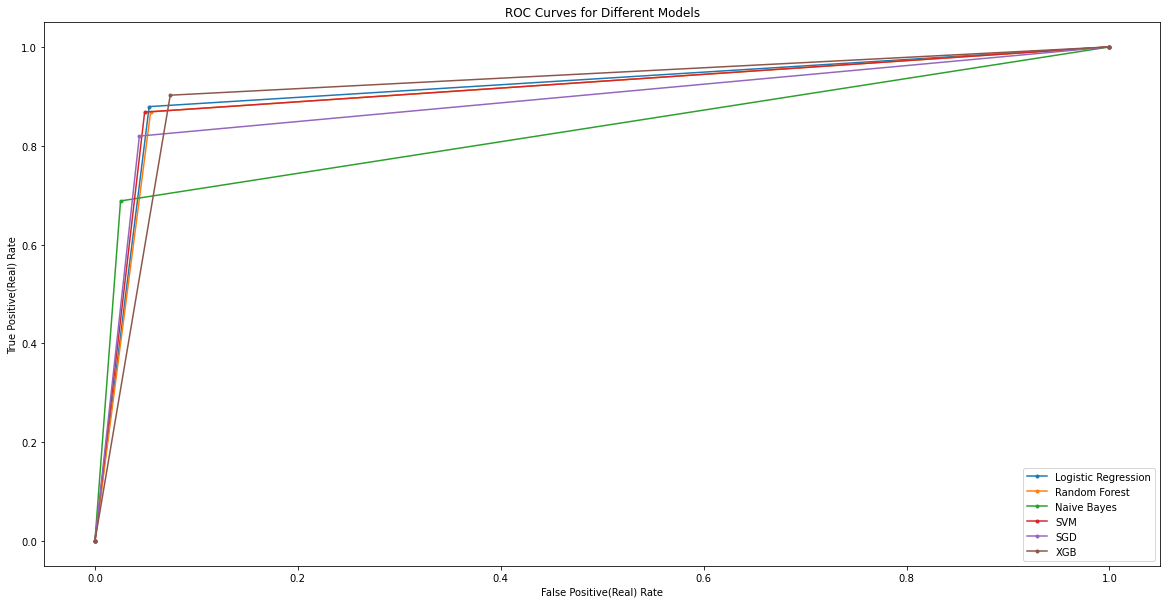

In [115]:
fpr1, tpr1 , _ = roc_curve(a1,predictions1)
fpr2, tpr2 , _ = roc_curve(a1,predictions2)
fpr3, tpr3 , _ = roc_curve(a1,predictions3)
fpr4, tpr4 , _ = roc_curve(a1,predictions4)
fpr5, tpr5 , _ = roc_curve(a1,predictions5)
fpr6, tpr6 , _ = roc_curve(a1,predictions6)

plt.figure(figsize=(20,10))

plt.plot(fpr1,tpr1,marker = '.',label = 'Logistic Regression')
plt.plot(fpr2,tpr2,marker = '.',label = 'Random Forest')
plt.plot(fpr3,tpr3,marker = '.',label = 'Naive Bayes')
plt.plot(fpr4,tpr4,marker = '.',label = 'SVM')
plt.plot(fpr5,tpr5,marker = '.',label = 'SGD')
plt.plot(fpr6,tpr6,marker = '.',label = 'XGB')

plt.xlabel('False Positive(Real) Rate')
plt.ylabel('True Positive(Real) Rate')
plt.title('ROC Curves for Different Models')
plt.legend()

print('Area under ROC of Logistic Regression: ',roc_auc_score(a1,predictions1))
print('Area under ROC of Random Forest: ',roc_auc_score(a1,predictions2))
print('Area under ROC of Naive Bayes: ',roc_auc_score(a1,predictions3))
print('Area under ROC of SVM: ',roc_auc_score(a1,predictions4))
print('Area under ROC of SGD: ',roc_auc_score(a1,predictions5))
print('Area under ROC of XGB: ',roc_auc_score(a1,predictions6))

XGB and Logistic Regression performed the best whereas Naive Bayes performed the worst 

# Source credibility

In [133]:
f = open("C:\\Users\\Sohaib Fazal\\Desktop\\Credentials.txt",'r')
lines = f.readlines()

In [136]:
import tweepy
consumer_key=lines[0][:-1]
consumer_secret=lines[1][:-1]
access_token=lines[2][:-1]
access_token_secret=[3][:-1]
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [117]:
def feature_transform(array_texts):
    
    df1 = pd.DataFrame(array_texts,columns = ['tweet'])
    feat1 = unitfidf_vectorizer.transform(array_texts).toarray()
    feat2 = bitfidf_vectorizer.transform(array_texts).toarray()
        
    count_cols = ['count_words','count_unique_words','count_letters','count_stopwords','count_hashtags','polarity','subjectivity']
    
    df1['count_words'] = df1['tweet'].apply(lambda x: len(str(x).split()))    
    df1['count_words'] = MinMax1.transform(np.array(df1['count_words']).reshape(-1,1))
        
    df1['count_unique_words'] = df1['tweet'].apply(lambda x: len(set(str(x).split())))
    df1['count_unique_words'] = MinMax2.transform(np.array(df1['count_unique_words']).reshape(-1,1))
        
    df1['count_letters'] = df1['tweet'].apply(lambda x: len(str(x)))
    df1['count_letters'] = MinMax3.transform(np.array(df1['count_letters']).reshape(-1,1))
        
    df1['count_stopwords'] = df1['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
    df1['count_stopwords'] = MinMax4.transform(np.array(df1['count_stopwords']).reshape(-1,1))
        
    df1['count_hashtags'] = df1['tweet'].apply(lambda x: len(re.findall(r'#([a-z0-9]+)', str(x))))
    df1['count_hashtags'] = MinMax5.transform(np.array(df1['count_hashtags']).reshape(-1,1))
        
    df1['polarity'] = [TextBlob(df1['tweet'][i]).sentiment.polarity for i in range(len(df1))]
    df1['subjectivity'] = [TextBlob(df1['tweet'][i]).sentiment.subjectivity for i in range(len(df1))]
        
    a1 = np.concatenate((feat1,feat2),axis=1)
    train_features1 = np.concatenate((a1,df1[count_cols]),axis=1)
    
    return train_features1


In [118]:
dict_source = {}

In [119]:
def source_credible(username):
    
    if username in dict_source:
        return dict_source[username]
    else:
        tweets = api.user_timeline(username,lang = 'en',tweet_mode = 'extended')
        array_texts_original = []
        array_texts = []
        
        for tweet in tweets:
            tweet = tweet._json
            array_texts_original.append(tweet['full_text'])
            translator = google_translator()  
            r = translator.translate(tweet['full_text'],lang_src='hi', lang_tgt='en')
            array_texts.append(preprocess(r))
        
        
        train_features1 = feature_transform(array_texts)

        prediction_model = model1.predict(train_features1)
        
        count_fake = 0
        
        for x in prediction_model:
            if x == 'fake':
                count_fake+=1
        
        credibility_fake = (count_fake)/len(prediction_model) 
        
        dict_source[username] = 1 - credibility_fake
        
        return array_texts_original,prediction_model,1-credibility_fake

In [120]:
tweets,predictions,credibility = source_credible('COVIDIOTS')
print('Source credibility is: ',credibility)

Source credibility is:  0.10526315789473684


In [187]:
print(tweets[6])
print('predicted label: ',predictions[6])

RT @sheel57: HS2 does seem to employ people with a tendency for aggressive and selfish behaviour! @covidiots @Andrew4Pendle
predicted label:  fake


In [188]:
tweets,predictions,credibility = source_credible('CovidVaccineLA')
print('Source credibility is: ',credibility)

Source credibility is:  1.0


In [121]:
tweets,predictions,credibility = source_credible('COVIDNewsByMIB')
print('Source credibility is: ',credibility)

Source credibility is:  0.44999999999999996


In [122]:
print(tweets[5])
print('predicted label: ',predictions[5])

#IndiaFightsCorona:

Follow protocol #T3, keep yourself #COVID- free

▶️𝑻𝒆𝒔𝒕 𝒘𝒉𝒆𝒏 𝒔𝒚𝒎𝒑𝒕𝒐𝒎𝒂𝒕𝒊𝒄
▶️𝑻𝒓𝒂𝒄𝒌 𝒕𝒉𝒆 𝒔𝒆𝒗𝒆𝒓𝒊𝒕𝒚
▶️𝑻𝒓𝒆𝒂𝒕 𝒘𝒊𝒕𝒉 𝒗𝒂𝒄𝒄𝒊𝒏𝒂𝒕𝒊𝒐𝒏 💉

#StaySafe #We4Vaccine #Unite2FightCorona https://t.co/N7WK5fMMep
predicted label:  real


In [127]:
print(predictions)

['real' 'real' 'real' 'fake' 'fake' 'real' 'real' 'real' 'fake' 'fake'
 'fake' 'real' 'real' 'fake' 'fake' 'fake' 'fake' 'fake' 'real' 'fake']


In [128]:
print(tweets[1])
print('predicted label: ',predictions[1])

#IndiaFightsCorona:

#COVID19Vaccination - Day 99

India crosses landmark of 14 Cr COVID-19 Vaccine doses

India is the fastest country to administer 14 Crore Doses of #COVID19Vaccine

More than 24 Lakh doses given in last 24 hours

Details: https://t.co/9ME3VNHAPk

#StaySafe https://t.co/LAVPF4MGvu
predicted label:  real


In [131]:
text = ["Take crocin for 3 days and covid will be finished",
        "Covid is finished","We already know the havoc #Covid19 can wreck! Please letâ€™s wear a mask correctly & stay home as much as possible. No one is safe till everyone is safe! We already know the havoc #Covid19 can wreck! Please letâ€™s wear a mask correctly & stay home as much as possible. No one is safe till everyone is safe!"]
t = []
for x in text:    
    t.append(preprocess(x))
    
t = feature_transform(t)
p = model6.predict(t)

In [132]:
p

array(['fake', 'fake', 'real'], dtype=object)

## Deep Learning models - BERT 

In [65]:
# GITHUB Link:- https://github.com/diptamath/covid_fake_news/blob/main/Boosting/model_predictions.ipynb

In [ ]:
# df_deep = df[['tweet']]
# df_labels = df[['label']]

In [ ]:
# df_deep.head()

In [ ]:
# df_train,df_test,y_train,y_test = train_test_split(df_deep,df_labels,test_size=0.3)

In [ ]:
# from simpletransformers.classification import ClassificationModel

In [ ]:
# model_args = {
#     "num_train_epochs": 1,
#     "learning_rate": 1,
# }
# model = ClassificationModel("bert", "bert-base-uncased", args=model_args,use_cuda=False)

In [ ]:
# df_train_model = pd.concat([df_train,y_train],axis=1)
# df_train_model = df_train_model.rename(columns = {'tweet': 'text', 'label': 'labels'}, inplace = False)

In [ ]:
# for i in range(len(df_train_model)):
#     if df_train_model.iloc[i]['labels'] == 'fake':
#         df_train_model.iloc[i]['labels'] = 0
#     else:
#         df_train_model.iloc[i]['labels'] = 1

In [ ]:
# y_test

In [ ]:
# df_train_model.head()

In [ ]:
# model.train_model(df_train_model)

In [ ]:
# a11 = []
# for i in range(len(y_test)):
#     x = y_test.iloc[i]['label']
#     if x == 'real':
#         a11.append(1)
#     else:
#         a11.append(0)

In [ ]:
# prediction_deep1 = model1.predict(df_test)
# prediction_deep1 = convert_label_to_int(prediction_deep1)
# print("Accuracy of Bert: ",accuracy_score(a11,prediction_deep1))

In [ ]:
def homepagefeed(listofhashtags):
    result=[]
    tweetsinhashtag=[]
    for hashtag in listofhashtags:
        tweetsinhashtag=[]
        cursor=tweepy.Cursor(api.search,q=hashtag,tweet_mode='extended',include_entities=True).items(20)
        for tw in cursor:
            tweetsinhashtag.append(tw.full_text)
        featuresinhashtag=feature_transform(tweetsinhashtag)
        prediction_modelonhashtag = model1.predict(featuresinhashtag)
        result.extend(prediction_modelonhashtag)
    return (tweetsinhashtag,result)

In [ ]:
def checktop20tweetsinhashtag(hashtag):
    tweetsinhashtag=[]
    cursor=tweepy.Cursor(api.search,q=hashtag,tweet_mode='extended',include_entities=True,result_type="popular").items(20)
    for tw in cursor:
        tweetsinhashtag.append(tw.full_text)
    featuresinhashtag=feature_transform(tweetsinhashtag)
    prediction_modelonhashtag = model1.predict(featuresinhashtag)
    return (tweetsinhashtag,prediction_modelonhashtag)

